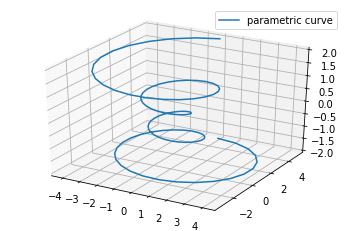

In [2]:
%matplotlib inline
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 10

fig = plt.figure()
ax = fig.gca(projection='3d')
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)
ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()

# Cookbook

In [76]:
from symenergy.core import model
from symenergy import logger
logger.setLevel('ERROR')

## Simple example

We set up a simple model with two time slots, gas power plants with a linear cost supply curve, and pumped-hydro storage (PHS) plants.

In [77]:
m = model.Model(curtailment=True)

m.add_slot(name='night', load=10, vre=1)
m.add_slot(name='day', load=10, vre=1)

m.add_storage(name='phs', eff=0.8)
m.add_plant(name='gas', vc0=0, vc1=1)

m.cache.delete_cached()
m.generate_solve()

## Investigate closed-form numerical solutions

All results are stored in the model attribute `df_comb`. This `pandas.DataFrame` is indexed by the inequality constraint combinations. The column names corresponding to the active/inactive constraints can be listed through the model's `constraints` collection: 

In [78]:
 m.constraints('col', is_equality_constraint=False)

['act_lb_gas_pos_p_day',
 'act_lb_gas_pos_p_night',
 'act_lb_phs_pos_pchg_day',
 'act_lb_phs_pos_pchg_night',
 'act_lb_phs_pos_pdch_day',
 'act_lb_phs_pos_pdch_night',
 'act_lb_phs_pos_e_day',
 'act_lb_phs_pos_e_night',
 'act_lb_curt_pos_p_day',
 'act_lb_curt_pos_p_night']

For example, to select the constraint combination where storage is inactive and all power is supplied from gas plants, we would select all columns where the positivity constraints of storage operation are active (`True`) and positivity constraints of gas power plant operation are inactive (`False`):

In [79]:
df_slct = m.df_comb.set_index('idx').query('act_lb_phs_pos_pchg_night and act_lb_phs_pos_pchg_day'
                                           ' and act_lb_phs_pos_pdch_night and act_lb_phs_pos_pdch_day'
                                           ' and not act_lb_gas_pos_p_night and not act_lb_gas_pos_p_day')
display(df_slct.T)

idx,4
act_lb_gas_pos_p_day,False
act_lb_gas_pos_p_night,False
act_lb_phs_pos_pchg_day,True
act_lb_phs_pos_pchg_night,True
act_lb_phs_pos_pdch_day,True
act_lb_phs_pos_pdch_night,True
act_lb_phs_pos_e_day,True
act_lb_phs_pos_e_night,True
act_lb_curt_pos_p_day,True
act_lb_curt_pos_p_night,True


Not that the only valid solution also has zero curtailment (active `act_lb_curt_pos_p_...` constraints). This is because simultaneous non-zero generator output and non-zero curtailment is excluded a-priori throught the definition of mutually exclusive constraints in the model class.

The filtered tablel above tells us the index of the relevant constraint combination. The model class provides a convenience method `print_results` to print the corresponding closed-form solutions for a given index.

In [80]:
m.print_results(m.df_comb, idx=df_slct.index.tolist()[0])

******************** curt_p_day ********************
0
******************** curt_p_night ********************
0
******************** gas_p_day ********************
l_day - vre_day*vre_scale_none
******************** gas_p_night ********************
l_night - vre_night*vre_scale_none
******************** lb_curt_pos_p_day ********************
-w_none*(vc0_gas_none + vc1_gas_none*(l_day - vre_day*vre_scale_none))
******************** lb_curt_pos_p_night ********************
-w_none*(vc0_gas_none + vc1_gas_none*(l_night - vre_night*vre_scale_none))
******************** lb_phs_pos_e_day ********************
0
******************** lb_phs_pos_e_night ********************
0
******************** lb_phs_pos_pchg_day ********************
0
******************** lb_phs_pos_pchg_night ********************
0
******************** lb_phs_pos_pdch_day ********************
0
******************** lb_phs_pos_pdch_night ********************
0
******************** phs_e_day ********************
0
**********

As expected, all storage operation is zero (charging `phs_pdch_day`, `phs_pdch_night`, discharging `phs_pdch_day`, `phs_pdch_night`, stored energy `phs_e_day`, `phs_e_night`). The gas power production is used to cover the residual load during the day `l_day - vre_day*vre_scale_none` and at night `l_night - vre_night*vre_scale_none`.

## Numerical evaluation

The :class:`symenergy.evaluator.evaluator.Evaluator` allows to evaluate the model results for certain parameter values

In [82]:
import numpy as np

import evaluator.evaluator as evaluator
from evaluator.evaluator import logger
logger.setLevel('ERROR')

x_vals = {
          m.vre_scale: np.linspace(0, 1.5, 31),
          m.slots['day'].vre: np.linspace(1, 9, 9),
          m.storages['phs'].eff: np.linspace(0.01, 0.99, 3),
         }

ev = evaluator.Evaluator(m, x_vals)

In [83]:
ev.expand_to_x_vals()
ev.build_supply_table()

The `evaluator.plotting` module provides classes to generate interactive Bokeh plots. Below we show the energy balance as a function of the VRE scaling parameter `'vre_scale_none'`, with horizontal subplots by `'slot'`. The remaining free parameters are added as lists from which values can be selected interactively.

In [75]:
import evaluator.plotting as plotting
from bokeh.io import show, output_notebook
output_notebook(verbose=False)

balplot = plotting.BalancePlot(ev, ind_axx='vre_scale_none', ind_pltx='slot', ind_plty=None)
show(balplot._get_layout())

Loading BokehJS ...

The evaluator results can also be used to determine relevant constraint combinations for further analysis. Based on the plots above, we might be interested in the optimal solution corresponding to the parameter values `vre_day == 9`, `eff_phs_non == 0.5` and `vre_scale_none == 1`.

In [66]:
df_slct = ev.df_exp.query('is_optimum'
                          ' and vre_day == 9'
                          ' and eff_phs_none == 0.5'
                          ' and vre_scale_none == 1')
display(df_slct[ev.x_name + ['idx', 'func', 'lambd', 'is_optimum']])

,vre_scale_none,vre_day,eff_phs_none,idx,func,lambd,is_optimum
1132,1.0,9.0,0.5,3,curt_p_day_lam_plot,0.000000,True
9070,1.0,9.0,0.5,3,curt_p_night_lam_plot,0.000000,True
17008,1.0,9.0,0.5,3,gas_p_day_lam_plot,3.799434,True
24946,1.0,9.0,0.5,3,gas_p_night_lam_plot,7.600283,True
32884,1.0,9.0,0.5,3,phs_e_day_lam_plot,1.979499,True
40822,1.0,9.0,0.5,3,phs_e_night_lam_plot,0.000000,True
48760,1.0,9.0,0.5,3,phs_pchg_day_lam_plot,2.799434,True
56698,1.0,9.0,0.5,3,phs_pchg_night_lam_plot,0.000000,True
64636,1.0,9.0,0.5,3,phs_pdch_day_lam_plot,0.000000,True
72574,1.0,9.0,0.5,3,phs_pdch_night_lam_plot,1.399717,True


The index of the corresponding constraint combination is thus 3. 

Again, we can print the results using the `Model.print_results` function to obtain the corresponding closed-form symbolic solutions.

In [72]:
m.print_results(m.df_comb, idx=df_slct.idx.tolist()[0])

******************** curt_p_day ********************
0
******************** curt_p_night ********************
0
******************** gas_p_day ********************
eff_phs_none**(-0.5)*(-eff_phs_none**0.5*(0.001*eff_phs_none**0.5 + vc0_gas_none)*(eff_phs_none**2.0 + 1) + eff_phs_none**1.5*(eff_phs_none**1.0*(vc0_gas_none - vc1_gas_none*(-l_day + vre_day*vre_scale_none)) + 0.001*eff_phs_none**1.5 + vc0_gas_none - vc1_gas_none*(-l_night + vre_night*vre_scale_none)))/(vc1_gas_none*(eff_phs_none**2.0 + 1))
******************** gas_p_night ********************
1.0*(1.0*eff_phs_none**1.0*l_day*vc1_gas_none + 1.0*eff_phs_none**1.0*vc0_gas_none - 1.0*eff_phs_none**1.0*vc1_gas_none*vre_day*vre_scale_none + 0.001*eff_phs_none**1.5 - 1.0*eff_phs_none**2.0*vc0_gas_none + 1.0*l_night*vc1_gas_none - 1.0*vc1_gas_none*vre_night*vre_scale_none)/(vc1_gas_none*(eff_phs_none**2.0 + 1))
******************** lb_curt_pos_p_day ********************
w_none*(0.001*eff_phs_none**0.5*(eff_phs_none**2.0 + 1) - eff